## Class Activation Map 만들기

### 학습 목표
- Classification model로부터 CAM을 얻어낼 수 있다.
- CAM으로 물체의 위치를 찾을 수 있다.
- CAM을 시각화 비교할 수 있다.

### 루브릭 
- CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가? : **ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.**
- 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가? : **CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.**
- 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가? : **CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.**


## 목차
### 0. 환경 설정
### 1. 데이터셋 및 모델 준비
#### 1) 데이터 로드
#### 2) 모델 로드
### 2. CAM
### 3. Grad-CAM
### 4. 바운딩박스 및 IoU 구하기
---

### 0. 환경 설정

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
from pathlib import Path

folder = 'Colab Notebooks'
project_dir = 'going_deeper_CV'

base_path = Path('/content/gdrive/My Drive')
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
  if x.is_dir():
    dir_name = str(x.relative_to(project_path))
    os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f'현재 디렉토리 위치: {os.getcwd()}')

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/going_deeper_CV


In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import copy
import cv2
import PIL

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


### 1. 데이터셋 및 모델 준비

#### 1) 데이터 로드 및 정규화

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', 
    split = ['train','test'],
    shuffle_files=True, 
    with_info=True, 
    data_dir=os.getcwd()+'/datasets'
    )

`tfds.load()` 메서드에서    
`as_supervised=True`일 경우, (input, label)의 2-tuple 형태로 불러오게 되고  
`as_supervised=False`일 경우 모든 feature의 dictionary 형태로 불러오게 된다.

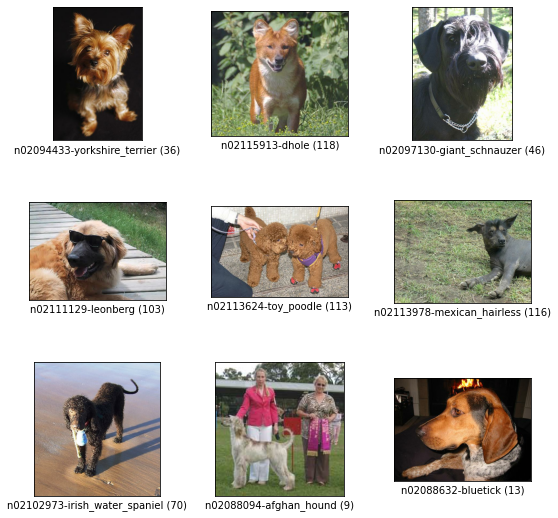

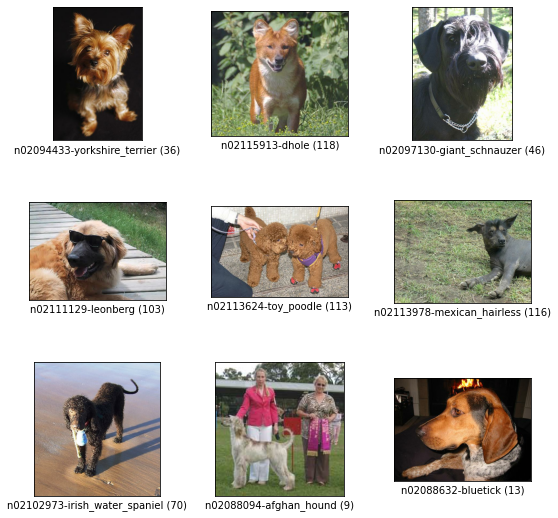

In [ ]:
tfds.show_examples(ds_train, ds_info)

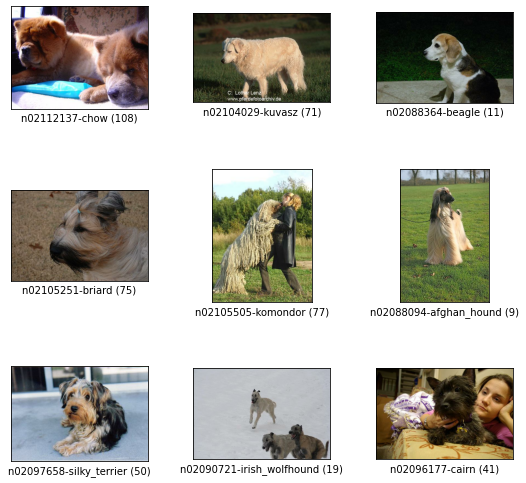

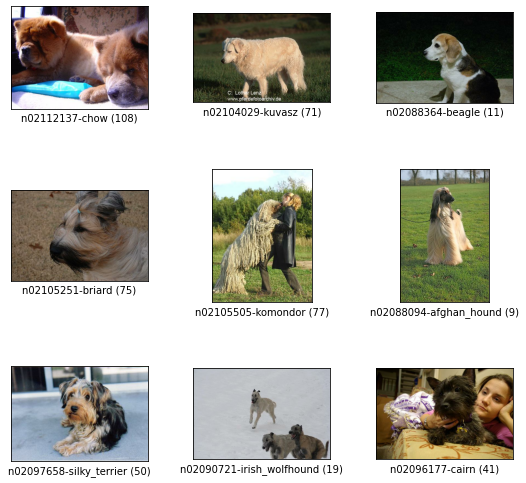

In [ ]:
tfds.show_examples(ds_test, ds_info)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

`bbox`: 물체의 위치 표기(바운딩박스)가 `BBoxFeature` 타입으로 라벨링 되어 있음.    
**[ymin, xmin, ymax, xmax]**로 표기됨.

In [ ]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train_norm = apply_normalize_on_dataset(ds_train, is_test=False)
ds_test_norm = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
# 이미지를 한장씩 뽑을 수 있도록 하는 함수
def get_one(ds):
  ds = ds.take(1)
  sample_data = list(ds.as_numpy_iterator())
  bbox = sample_data[0]['objects']['bbox']
  image = sample_data[0]['image']
  label = sample_data[0]['label']
  return sample_data[0]

#### 2) 모델 학습

In [ ]:
num_classes = ds_info.features['label'].num_classes

In [ ]:
base_model = keras.applications.resnet50.ResNet50(
    include_top = False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling = 'avg'
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 105s 124ms/step - loss: 2.1719 - accuracy: 0.4505 - val_loss: 3.3550 - val_accuracy: 0.2085
Epoch 2/10
750/750 [==============================] - 89s 118ms/step - loss: 0.7573 - accuracy: 0.7857 - val_loss: 1.0554 - val_accuracy: 0.6929
Epoch 3/10
750/750 [==============================] - 89s 118ms/step - loss: 0.2339 - accuracy: 0.9490 - val_loss: 0.9590 - val_accuracy: 0.7188
Epoch 4/10
750/750 [==============================] - 90s 120ms/step - loss: 0.0635 - accuracy: 0.9929 - val_loss: 0.9074 - val_accuracy: 0.7410
Epoch 5/10
750/750 [==============================] - 89s 119ms/step - loss: 0.0221 - accuracy: 0.9994 - val_loss: 0.9164 - val_accuracy: 0.7425
Epoch 6/10
750/750 [==============================] - 89s 119ms/step - loss: 0.0128 - accuracy: 0.9999 - val_loss: 0.9242 - val_accuracy: 0.7429
Epoch 7/10
750/750 [==============================] - 92s 122ms/step - loss: 0.0097 - accuracy: 0.9999 - val_loss: 0.9442 - val_a

In [ ]:
# 가중치 저장
cam_model_path = os.getcwd()+'/models/cam_model1.h5'
cam_model.save(cam_model_path)

### 2. CAM
CAM을 얻기 위해서는 다음 세가지가 준비되어야 한다.
* GAP을 적용하기 직전의 feature map `conv5_block3_out[0][0]`
* 클래스별 확률을 얻기 위한 softmax 레이어의 가중치 `conv5_block3_out (Activation)` layer의 output
* 원하는 클래스의 출력값인 모델의 최종 output

67


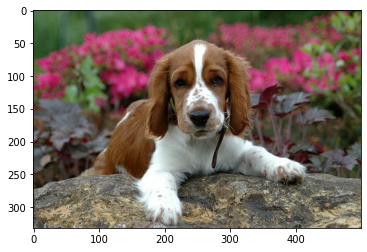

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
def generate_cam(model, item):
  item = copy.deepcopy(item)
  width = item['image'].shape[1]
  height = item['image'].shape[0]
  img_tensor, class_idx = normalize_and_resize_img(item)

  # GAP을 적용하기 전 feature map과 model이 predict한 결과를 함께 output으로 내는 모델
  cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
  conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))

  conv_outputs = conv_outputs[0,:,:,:]
  class_weights = model.layers[-1].get_weights()[0]    # 마지막 모델의 weight activation

  cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for i, w in enumerate(class_weights[:,class_idx]):
    cam_image += w * conv_outputs[:,:,i]

  cam_image /= np.max(cam_image)
  cam_image = cam_image.numpy()
  cam_image = cv2.resize(cam_image, (width, height))
  return cam_image

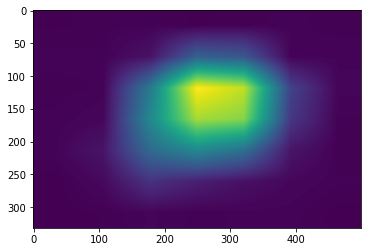

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def visualize_cam_on_image(src1, src2, alpha = 0.5):
  beta = (1.0 - alpha)
  merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
  return merged_image

* `cv2.addWeighted()`

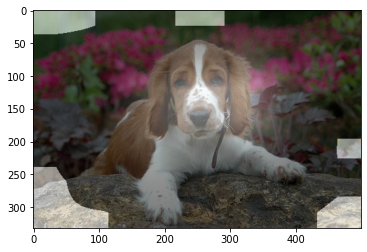

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### 3. Grad-CAM
Grad-CAM은 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, GAP을 적용하여 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.    
따라서 CAM과는 달리 확인하고자 하는 activation layer를 직접 지정하여, CAM을 단계별로 확인할 수 있다.

36


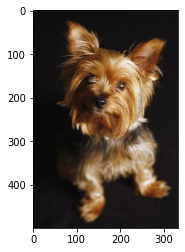

In [ ]:
item = get_one(ds_train)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
def generate_grad_cam(model, activation_layer, item):    # CAM과는 달리 확인하고자 하는 feature map을 activation_layer 변수로 직접 지정함

  item = copy.deepcopy(item)
  width = item['image'].shape[1]
  height = item['image'].shape[0]
  img_tensor, class_idx = normalize_and_resize_img(item)

  # GAP을 적용하기 전 feature map과 model이 predict한 결과를 함께 output으로 내는 모델
  grad_model = tf.keras.models.Model([model.inputs],[model.get_layer(activation_layer).output, model.output])

  with tf.GradientTape() as tape:
    conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))

    loss = pred[:,class_idx]
    output = conv_output[0]
    grad_val = tape.gradient(loss, conv_output)[0]

  weights = np.mean(grad_val, axis = (0,1))
  grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])

  for k, w in enumerate(weights):
    grad_cam_image += w * output[:,:,k]

  grad_cam_image = tf.math.maximum(0, grad_cam_image)
  grad_cam_image /= np.max(grad_cam_image)
  grad_cam_image = grad_cam_image.numpy()
  grad_cam_image = cv2.resize(grad_cam_image, (width, height))
  return grad_cam_image

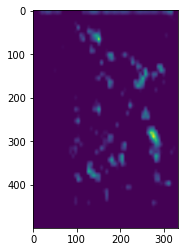

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

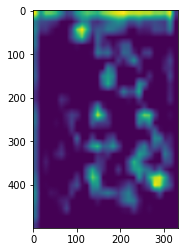

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block4_out', item)
plt.imshow(grad_cam_image)
plt.show()

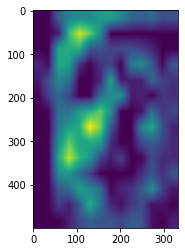

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block6_out', item)
plt.imshow(grad_cam_image)
plt.show()

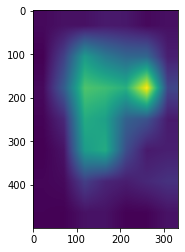

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

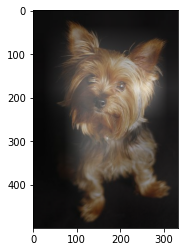

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### 4. 바운딩박스 및 IoU 구하기
* IoU(Intersection over Union): 두 영역의 교집합(intersection) 넓이를 합집합(union) 넓이로 나눈 값: 찾고자 하는 물건의 영역을 정확히 찾았는지 비교하는 지표. IoU≥0.5이면 관습적으로 맞는 바운딩박스를 찾았다고 가정한다.

80


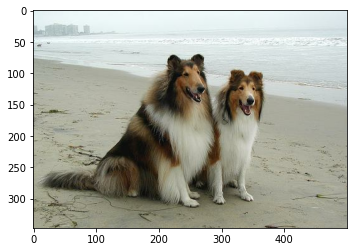

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
  low_indicies = cam_image <= score_thresh
  cam_image[low_indicies] = 0
  cam_image = (cam_image*255).astype(np.uint8)

  contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]
  rotated_rect = cv2.minAreaRect(cnt)
  rect = cv2.boxPoints(rotated_rect)
  rect = np.int0(rect)
  return rect

In [ ]:
def rect_to_minmax(rect,image):
  bbox = [
          rect[:,1].min()/float(image.shape[0]),   
          rect[:,0].min()/float(image.shape[1]),   
          rect[:,1].max()/float(image.shape[0]),  
          rect[:,0].max()/float(image.shape[1])
  ]
  return bbox

In [ ]:
def get_iou(boxA, boxB):
  y_min = max(boxA[0], boxB[0])
  x_min = max(boxA[1], boxB[1])
  y_max = min(boxA[2], boxB[2])
  x_max = min(boxA[3], boxB[3])

  interArea = max(0, x_max-x_min) * max(0, y_max-y_min)
  boxAArea = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
  boxBArea = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
  iou = interArea / float(boxAArea + boxBArea - interArea)

  return iou

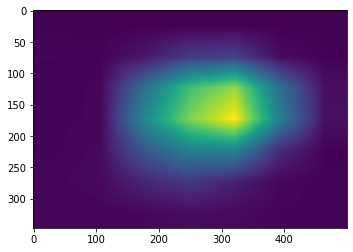

In [ ]:
# CAM 이미지
cam_image = generate_cam(cam_model,item)
plt.imshow(cam_image)
plt.show()

In [ ]:
# CAM의 bbox
rect = get_bbox(cam_image)
rect

array([[114, 311],
       [114,  40],
       [460,  40],
       [460, 311]])

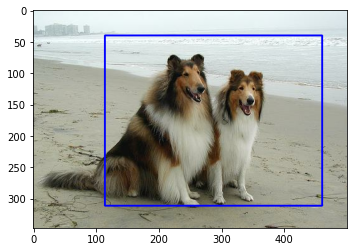

In [ ]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255),2)
plt.imshow(image)
plt.show()

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.11527377521613832, 0.228, 0.8962536023054755, 0.92]

In [ ]:
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [ ]:
# CAM의 iou
get_iou(pred_bbox, item['objects']['bbox'][0])

0.35474452548773916

grad-CAM 이미지는 layer의 순서, 원본 이미지에서 나온 feature map을 순서대로 확인해보도록 한다.

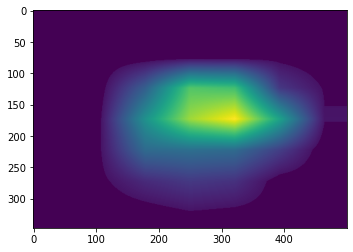

In [ ]:
grad_cam_image1 = generate_grad_cam(cam_model, 'conv2_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

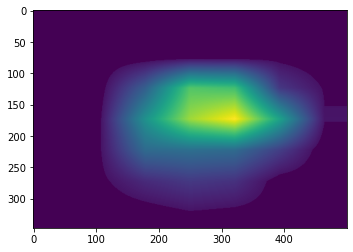

In [ ]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv3_block4_out', item)
plt.imshow(grad_cam_image)
plt.show()

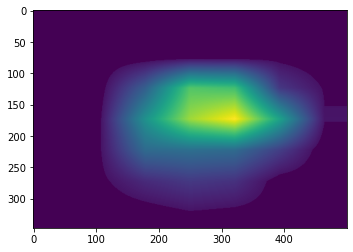

In [ ]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv4_block6_out', item)
plt.imshow(grad_cam_image)
plt.show()

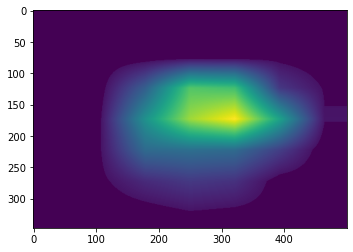

In [ ]:
grad_cam_image4 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

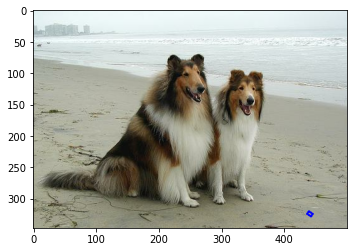

In [ ]:
rect = get_bbox(grad_cam_image1)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255),2)
plt.imshow(image)
plt.show()

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.9221902017291066, 0.872, 0.9452449567723343, 0.89]

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.0

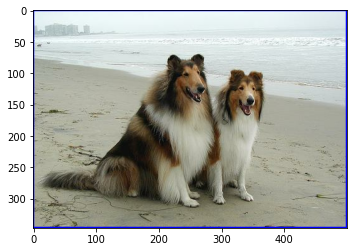

In [ ]:
rect = get_bbox(grad_cam_image2)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255),2)
plt.imshow(image)
plt.show()

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.0, 0.9971181556195965, 0.998]

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.39752338642633633

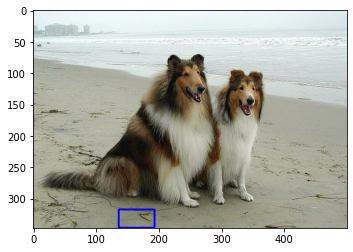

In [ ]:
rect = get_bbox(grad_cam_image3)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255),2)
plt.imshow(image)
plt.show()

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.9135446685878963, 0.272, 0.9971181556195965, 0.386]

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.0

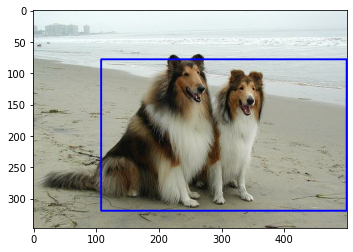

In [ ]:
rect = get_bbox(grad_cam_image4)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255),2)
plt.imshow(image)
plt.show()

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.22478386167146974, 0.216, 0.9193083573487032, 0.998]

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.35552521603150433

grad-CAM의 바운딩박스는 점진적으로 대상에 가까워지지는 않고 있다. feature와 관계 없는 지점에서 활성화가 되거나(`grad_cam_image1`, `grad_cam_image3`), 이미지 전체에서 활성화 되는 경우(`grad_cam_image2`를 거쳐 대상에 가까운 결과를 얻는다.     
최종 IoU는 CAM에 비해 근소하게 높지만 큰 차이는 없었다.

## 회고
* XAI에 대해 흥미를 가지고 있던 부분을 직접 구현해볼 수 있는 프로젝트였다. 최종 IoU가 0.5를 넘기지 않아, 모델 학습 epoch을 늘려 추가 실험을 진행해볼 필요가 있을 것 같다.
* 단계별로 이미지가 대상을 식별하는 과정을 시각화하여 연속적으로 보면 점진적으로 대상에 가까워지기 보다는 엉뚱한 곳을 가리키기도 하고, 전체 윤곽을 가리키다가 대상을 찾아내는 과정으로 이어지는 것 같다. 노드 설명에 의하면 주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 것은 사람이 개를 식별할 때 유의해서 보는 부분과 같다고 하는데, 모델이 개라는 대상을 식별할 때 이미지의 이곳저곳을 두리번거리다가 개를 포착하는 과정처럼도 보인다.
* ResNet50 뿐만 아니라 다른 모델들은 어떤 식으로 CAM이 전개될 지 궁금하다.